# Face Training Telemetry Analysis

Analyzing the training run to understand why it didn't converge.

**Key metrics tracked:**
- Gradient norms (overall, backbone, embedding, arcface)
- Weight deltas (how much weights changed)
- ArcFace weight statistics
- Learning rates

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Configure paths - adjust if needed
TELEMETRY_DIR = Path("../outputs/face/20260123_110841/telemetry")
# Alternative for RunPod:
# TELEMETRY_DIR = Path("/workspace/sim-bench/outputs/face/20260123_110841/telemetry")

print(f"Looking for telemetry in: {TELEMETRY_DIR.absolute()}")
print(f"Files found: {list(TELEMETRY_DIR.glob('*.csv'))}")

Looking for telemetry in: d:\sim-bench\notebooks\..\outputs\face\20260123_110841\telemetry
Files found: [WindowsPath('../outputs/face/20260123_110841/telemetry/arcface_stats.csv'), WindowsPath('../outputs/face/20260123_110841/telemetry/gradient_norms.csv'), WindowsPath('../outputs/face/20260123_110841/telemetry/learning_rates.csv'), WindowsPath('../outputs/face/20260123_110841/telemetry/weight_deltas.csv')]


In [2]:
# Load all telemetry data
gradient_norms = pd.read_csv(TELEMETRY_DIR / 'gradient_norms.csv')
weight_deltas = pd.read_csv(TELEMETRY_DIR / 'weight_deltas.csv')
arcface_stats = pd.read_csv(TELEMETRY_DIR / 'arcface_stats.csv')
learning_rates = pd.read_csv(TELEMETRY_DIR / 'learning_rates.csv')

print(f"Gradient norms: {len(gradient_norms)} rows")
print(f"Weight deltas: {len(weight_deltas)} rows")
print(f"ArcFace stats: {len(arcface_stats)} rows")
print(f"Learning rates: {len(learning_rates)} rows")

Gradient norms: 360 rows
Weight deltas: 359 rows
ArcFace stats: 360 rows
Learning rates: 360 rows


In [12]:
gradient_norms['batch_idx'].min(), gradient_norms['batch_idx'].max()

(100, 7200)

In [13]:
# Create a global step index for plotting
gradient_norms['step'] = gradient_norms['epoch'] * 1000 + gradient_norms['batch_idx'] // 100 
weight_deltas['step'] = weight_deltas['epoch'] * 1000 + weight_deltas['batch_idx'] // 100 
arcface_stats['step'] = arcface_stats['epoch'] * 1000 + arcface_stats['batch_idx'] // 100 

# Show data structure
print("=== Gradient Norms ===")
display(gradient_norms.head())
print("\n=== Weight Deltas ===")
display(weight_deltas.head())
print("\n=== ArcFace Stats ===")
display(arcface_stats.head())

=== Gradient Norms ===


,batch_idx,epoch,overall,backbone,embedding,arcface,step
0,100,0,21.391189,14.101650,1.165676,16.042681,1
1,200,0,17.931640,9.439779,0.930312,15.217385,2
2,300,0,15.240934,1.012839,0.500239,15.199013,3
3,400,0,13.941008,5.262222,0.428028,12.902617,4
4,500,0,5.425089,0.800921,0.440661,5.347517,5



=== Weight Deltas ===


,batch_idx,epoch,backbone_delta,embedding_delta,arcface_delta,step
0,200,0,13.544207,25.220218,133.497726,2
1,300,0,7.409840,15.490758,118.889984,3
2,400,0,2.141829,7.593297,104.503616,4
3,500,0,3.407276,11.058126,89.396858,5
4,600,0,0.770206,5.011860,78.900642,6



=== ArcFace Stats ===


,batch_idx,epoch,weight_mean,weight_std,weight_norm_mean,weight_norm_std,step
0,100,0,-0.000056,0.083614,1.274230,1.398594,1
1,200,0,0.000158,0.101245,1.785721,1.435152,2
2,300,0,0.000353,0.110960,2.097451,1.380132,3
3,400,0,0.000551,0.115975,2.295784,1.271314,4
4,500,0,0.000688,0.117696,2.404308,1.145472,5


## 1. Gradient Norms Analysis

Healthy training should show:
- Gradients that are neither too large (exploding) nor too small (vanishing)
- Relatively stable gradients over time
- Backbone gradients typically smaller than head gradients (with differential LR)

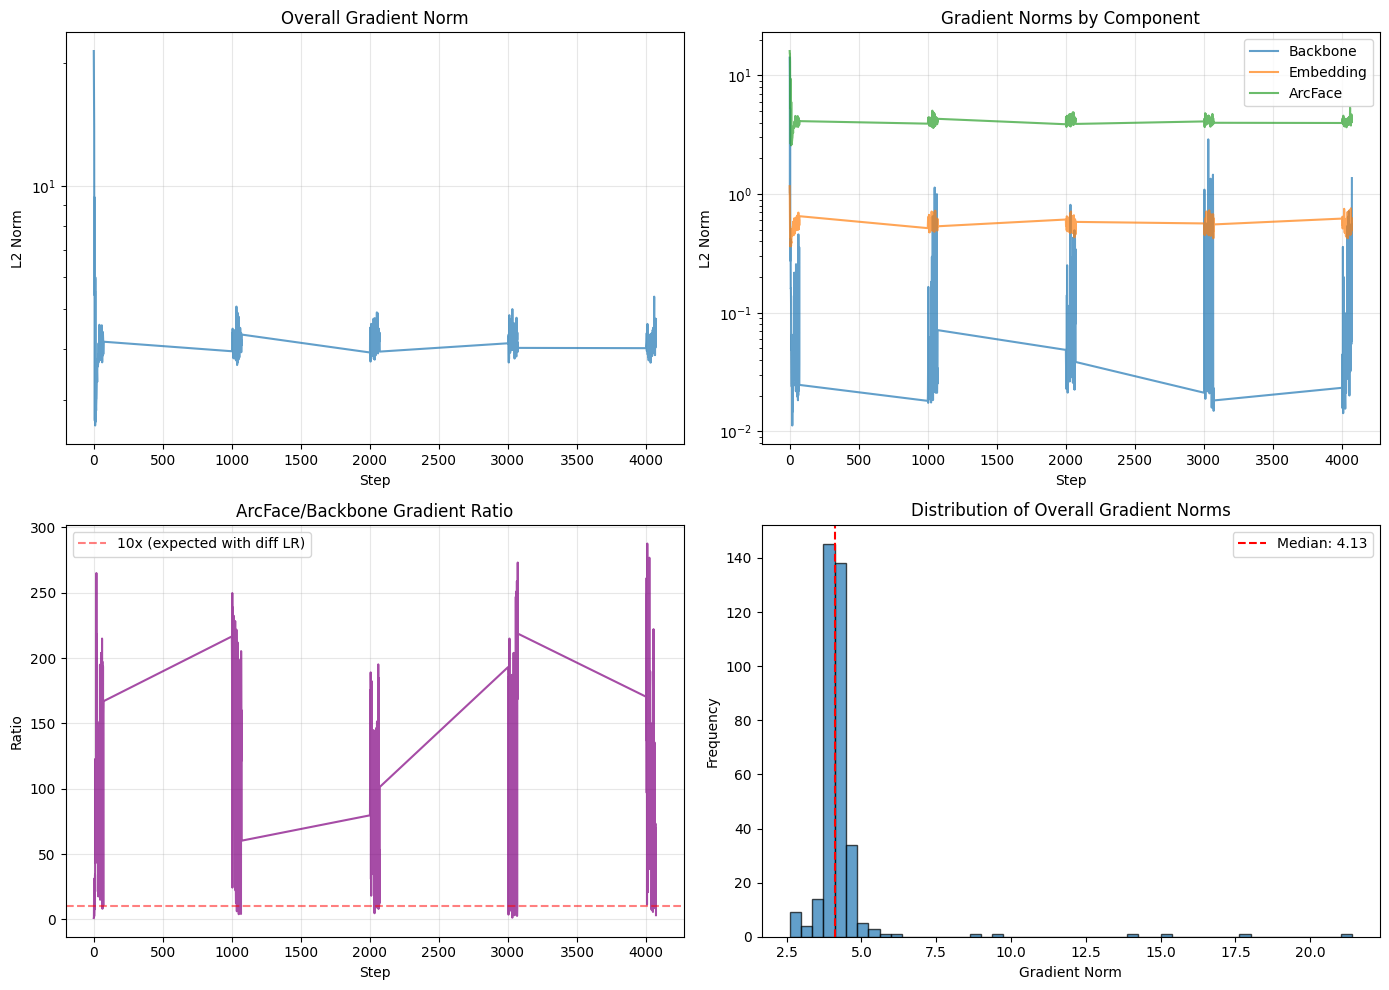


Gradient Statistics:
          overall    backbone   embedding     arcface
count  360.000000  360.000000  360.000000  360.000000
mean     4.301152    0.205209    0.559278    4.228432
std      1.495231    0.959040    0.078975    1.255321
min      2.603023    0.011219    0.362500    2.574312
25%      3.958914    0.025502    0.511771    3.914544
50%      4.132155    0.034360    0.553098    4.087478
75%      4.332741    0.093363    0.605660    4.290295
max     21.391189   14.101650    1.165676   16.042681


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall gradient norm
ax = axes[0, 0]
ax.plot(gradient_norms['step'], gradient_norms['overall'], alpha=0.7)
ax.set_xlabel('Step')
ax.set_ylabel('L2 Norm')
ax.set_title('Overall Gradient Norm')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Component breakdown
ax = axes[0, 1]
ax.plot(gradient_norms['step'], gradient_norms['backbone'], label='Backbone', alpha=0.7)
ax.plot(gradient_norms['step'], gradient_norms['embedding'], label='Embedding', alpha=0.7)
ax.plot(gradient_norms['step'], gradient_norms['arcface'], label='ArcFace', alpha=0.7)
ax.set_xlabel('Step')
ax.set_ylabel('L2 Norm')
ax.set_title('Gradient Norms by Component')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Ratio of arcface to backbone gradients
ax = axes[1, 0]
ratio = gradient_norms['arcface'] / (gradient_norms['backbone'] + 1e-8)
ax.plot(gradient_norms['step'], ratio, alpha=0.7, color='purple')
ax.set_xlabel('Step')
ax.set_ylabel('Ratio')
ax.set_title('ArcFace/Backbone Gradient Ratio')
ax.axhline(y=10, color='r', linestyle='--', alpha=0.5, label='10x (expected with diff LR)')
ax.legend()
ax.grid(True, alpha=0.3)

# Distribution of gradients
ax = axes[1, 1]
ax.hist(gradient_norms['overall'], bins=50, alpha=0.7, edgecolor='black')
ax.set_xlabel('Gradient Norm')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Overall Gradient Norms')
ax.axvline(x=gradient_norms['overall'].median(), color='r', linestyle='--', label=f'Median: {gradient_norms["overall"].median():.2f}')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nGradient Statistics:")
print(gradient_norms[['overall', 'backbone', 'embedding', 'arcface']].describe())

## 2. Weight Deltas Analysis

Weight deltas show how much the weights actually changed between telemetry collections.

**What to look for:**
- If deltas are very small, learning is slow
- If deltas are huge, learning may be unstable
- Relative magnitudes between components

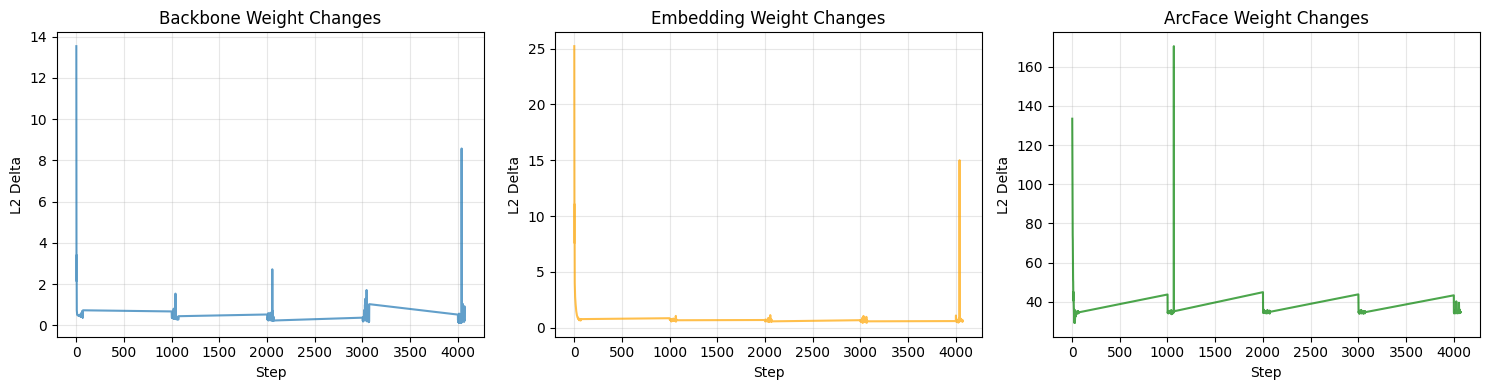


Weight Delta Statistics:
       backbone_delta  embedding_delta  arcface_delta
count      359.000000       359.000000     359.000000
mean         0.474433         0.971805      36.621501
std          0.941949         1.856987      11.767270
min          0.115032         0.432603      29.199778
25%          0.260002         0.598647      34.375134
50%          0.339586         0.666296      34.686096
75%          0.448268         0.748420      35.008482
max         13.544207        25.220218     170.558197


In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Backbone weight deltas
ax = axes[0]
ax.plot(weight_deltas['step'], weight_deltas['backbone_delta'], alpha=0.7)
ax.set_xlabel('Step')
ax.set_ylabel('L2 Delta')
ax.set_title('Backbone Weight Changes')
ax.grid(True, alpha=0.3)

# Embedding weight deltas
ax = axes[1]
ax.plot(weight_deltas['step'], weight_deltas['embedding_delta'], alpha=0.7, color='orange')
ax.set_xlabel('Step')
ax.set_ylabel('L2 Delta')
ax.set_title('Embedding Weight Changes')
ax.grid(True, alpha=0.3)

# ArcFace weight deltas
ax = axes[2]
ax.plot(weight_deltas['step'], weight_deltas['arcface_delta'], alpha=0.7, color='green')
ax.set_xlabel('Step')
ax.set_ylabel('L2 Delta')
ax.set_title('ArcFace Weight Changes')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nWeight Delta Statistics:")
print(weight_deltas[['backbone_delta', 'embedding_delta', 'arcface_delta']].describe())

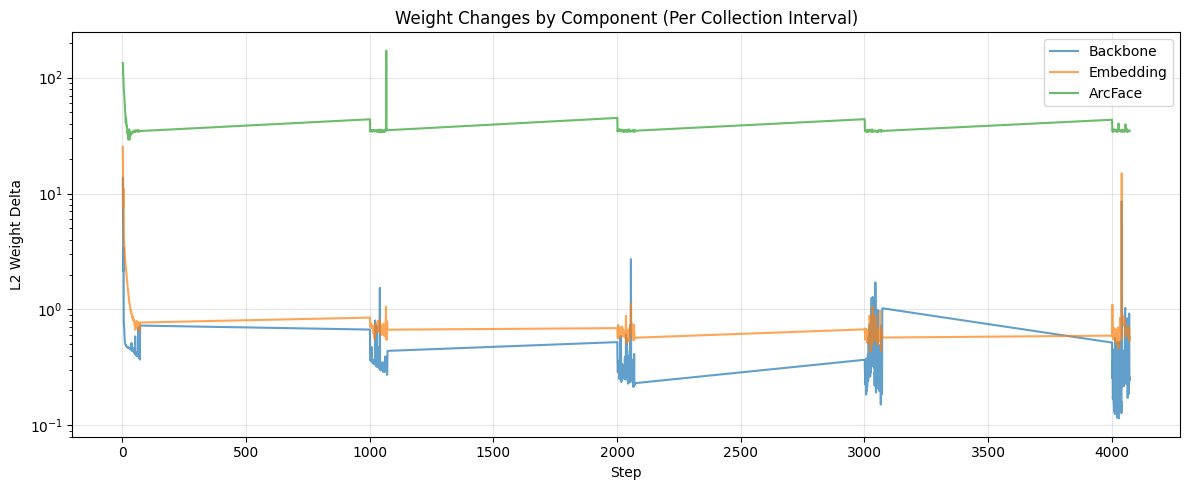

In [16]:
# Compare all components on same plot
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(weight_deltas['step'], weight_deltas['backbone_delta'], label='Backbone', alpha=0.7)
ax.plot(weight_deltas['step'], weight_deltas['embedding_delta'], label='Embedding', alpha=0.7)
ax.plot(weight_deltas['step'], weight_deltas['arcface_delta'], label='ArcFace', alpha=0.7)

ax.set_xlabel('Step')
ax.set_ylabel('L2 Weight Delta')
ax.set_title('Weight Changes by Component (Per Collection Interval)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

## 3. ArcFace Weight Statistics

The ArcFace weight matrix is crucial - it represents class prototypes in the embedding space.

**What to look for:**
- `weight_norm_mean` should be close to 1.0 (weights are normalized during forward pass)
- `weight_norm_std` should be small (consistent class prototypes)
- `weight_mean` and `weight_std` show the raw weight distribution

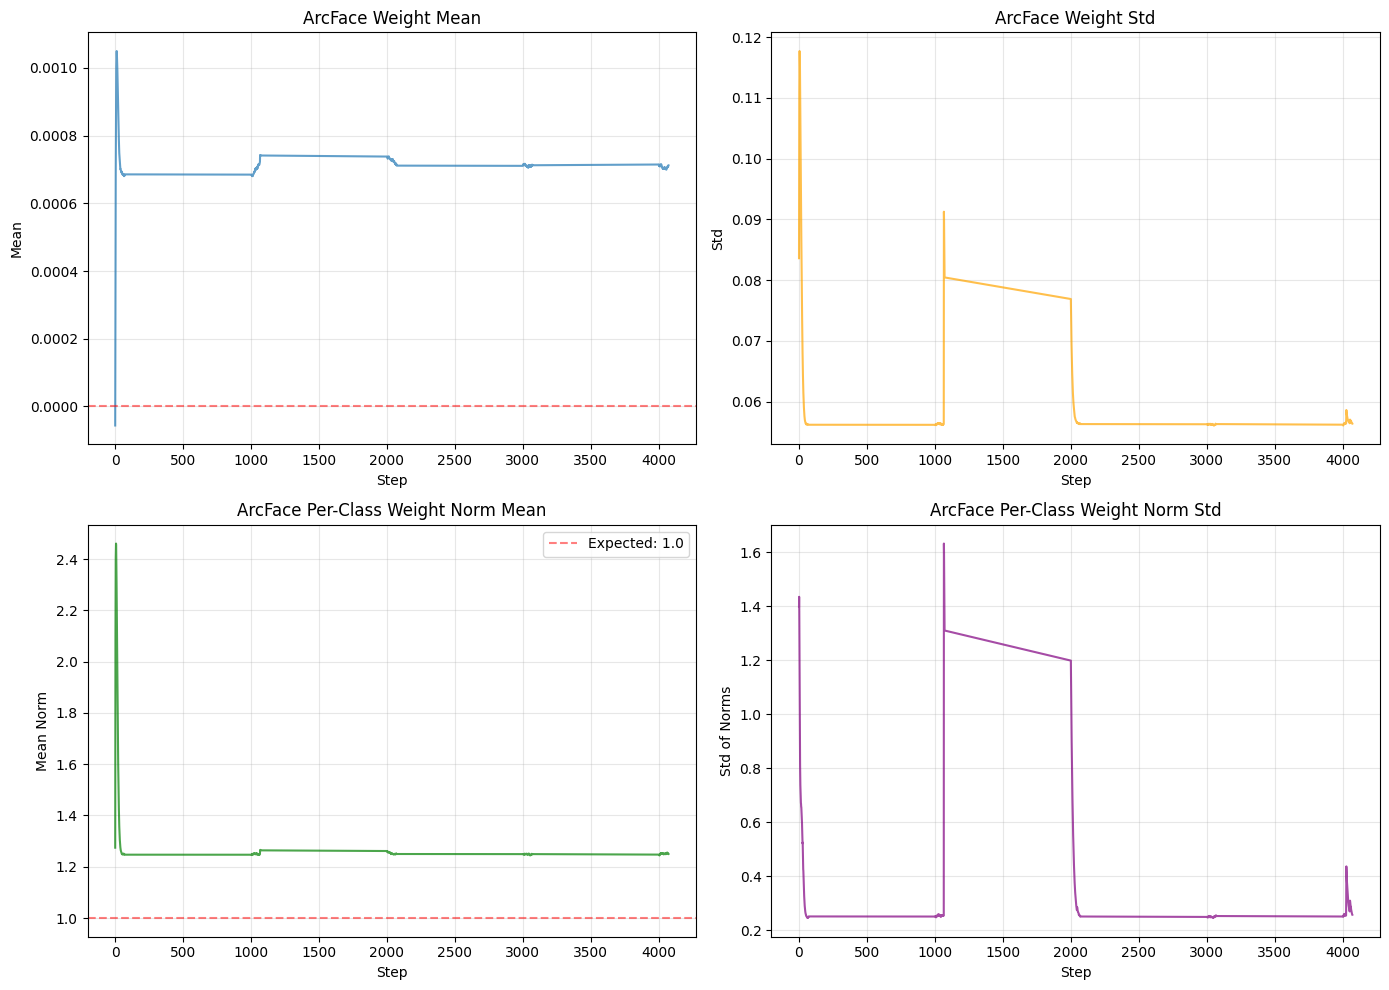


ArcFace Statistics:
       weight_mean  weight_std  weight_norm_mean  weight_norm_std
count   360.000000  360.000000        360.000000       360.000000
mean      0.000720    0.060617          1.307215         0.366016
std       0.000082    0.011674          0.213351         0.251382
min      -0.000056    0.056090          1.243954         0.245568
25%       0.000703    0.056294          1.248632         0.251701
50%       0.000711    0.056421          1.250036         0.256999
75%       0.000723    0.057214          1.252710         0.325159
max       0.001050    0.117696          2.460566         1.632380


In [17]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Weight mean
ax = axes[0, 0]
ax.plot(arcface_stats['step'], arcface_stats['weight_mean'], alpha=0.7)
ax.set_xlabel('Step')
ax.set_ylabel('Mean')
ax.set_title('ArcFace Weight Mean')
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)

# Weight std
ax = axes[0, 1]
ax.plot(arcface_stats['step'], arcface_stats['weight_std'], alpha=0.7, color='orange')
ax.set_xlabel('Step')
ax.set_ylabel('Std')
ax.set_title('ArcFace Weight Std')
ax.grid(True, alpha=0.3)

# Weight norm mean (should be ~1 after normalization)
ax = axes[1, 0]
ax.plot(arcface_stats['step'], arcface_stats['weight_norm_mean'], alpha=0.7, color='green')
ax.set_xlabel('Step')
ax.set_ylabel('Mean Norm')
ax.set_title('ArcFace Per-Class Weight Norm Mean')
ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Expected: 1.0')
ax.legend()
ax.grid(True, alpha=0.3)

# Weight norm std
ax = axes[1, 1]
ax.plot(arcface_stats['step'], arcface_stats['weight_norm_std'], alpha=0.7, color='purple')
ax.set_xlabel('Step')
ax.set_ylabel('Std of Norms')
ax.set_title('ArcFace Per-Class Weight Norm Std')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nArcFace Statistics:")
print(arcface_stats[['weight_mean', 'weight_std', 'weight_norm_mean', 'weight_norm_std']].describe())

## 4. Learning Rate Check

Learning Rate Schedule:
    batch_idx  epoch  lr_group_0  lr_group_1
0         100      0        0.01         0.1
1         200      0        0.01         0.1
2         300      0        0.01         0.1
3         400      0        0.01         0.1
4         500      0        0.01         0.1
5         600      0        0.01         0.1
6         700      0        0.01         0.1
7         800      0        0.01         0.1
8         900      0        0.01         0.1
9        1000      0        0.01         0.1
10       1100      0        0.01         0.1
11       1200      0        0.01         0.1
12       1300      0        0.01         0.1
13       1400      0        0.01         0.1
14       1500      0        0.01         0.1
15       1600      0        0.01         0.1
16       1700      0        0.01         0.1
17       1800      0        0.01         0.1
18       1900      0        0.01         0.1
19       2000      0        0.01         0.1


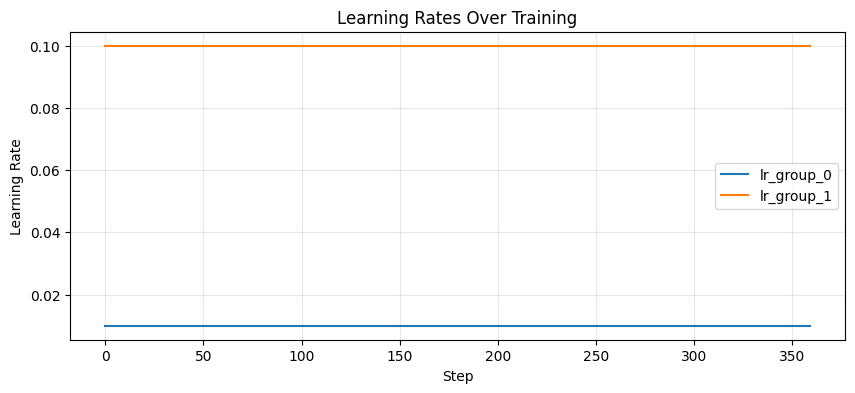

In [18]:
print("Learning Rate Schedule:")
print(learning_rates.head(20))

# Plot if there are multiple groups
lr_cols = [c for c in learning_rates.columns if c.startswith('lr_group')]
if lr_cols:
    fig, ax = plt.subplots(figsize=(10, 4))
    for col in lr_cols:
        ax.plot(range(len(learning_rates)), learning_rates[col], label=col)
    ax.set_xlabel('Step')
    ax.set_ylabel('Learning Rate')
    ax.set_title('Learning Rates Over Training')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

## 5. Epoch-Level Analysis

Aggregate statistics per epoch to see trends.

In [9]:
# Aggregate by epoch
epoch_grad = gradient_norms.groupby('epoch').agg({
    'overall': ['mean', 'std', 'max'],
    'backbone': 'mean',
    'embedding': 'mean',
    'arcface': 'mean'
}).round(4)

epoch_deltas = weight_deltas.groupby('epoch').agg({
    'backbone_delta': ['mean', 'sum'],
    'embedding_delta': ['mean', 'sum'],
    'arcface_delta': ['mean', 'sum']
}).round(4)

print("=== Gradient Norms by Epoch ===")
display(epoch_grad)

print("\n=== Weight Deltas by Epoch ===")
display(epoch_deltas)

=== Gradient Norms by Epoch ===


overall                  backbone embedding arcface
         mean     std      max     mean      mean    mean
epoch                                                    
0      4.7789  3.2744  21.3912   0.5009    0.5374  4.6148
1      4.1715  0.2895   5.0815   0.0802    0.5777  4.1260
2      4.1906  0.2719   4.9182   0.1034    0.5625  4.1481
3      4.1812  0.2522   5.0092   0.2107    0.5560  4.1160
4      4.1835  0.2682   5.3733   0.1309    0.5627  4.1372


=== Weight Deltas by Epoch ===


backbone_delta          embedding_delta           arcface_delta  \
                mean      sum            mean       sum          mean   
epoch                                                                   
0             0.8173  58.0301          2.0680  146.8298       41.7086   
1             0.3719  26.7785          0.6904   49.7076       36.7800   
2             0.3521  25.3537          0.6434   46.3221       34.8910   
3             0.4116  29.6382          0.6098   43.9071       34.7706   
4             0.4239  30.5210          0.8627   62.1115       35.0279   

                  
             sum  
epoch             
0      2961.3131  
1      2648.1607  
2      2512.1529  
3      2503.4858  
4      2522.0062

## 6. Diagnostic Summary

Key questions to answer:
1. Are gradients exploding or vanishing?
2. Is the model actually updating (weight deltas > 0)?
3. Is one component dominating training?
4. Are the ArcFace weights becoming degenerate?

In [10]:
print("=" * 60)
print("DIAGNOSTIC SUMMARY")
print("=" * 60)

# Gradient analysis
grad_overall_mean = gradient_norms['overall'].mean()
grad_overall_max = gradient_norms['overall'].max()
print(f"\n1. GRADIENT NORMS:")
print(f"   Overall mean: {grad_overall_mean:.4f}")
print(f"   Overall max:  {grad_overall_max:.4f}")
if grad_overall_mean > 100:
    print("   ⚠️  WARNING: Gradients are VERY LARGE - possible explosion")
elif grad_overall_mean < 0.001:
    print("   ⚠️  WARNING: Gradients are VERY SMALL - possible vanishing")
else:
    print("   ✓ Gradient magnitude looks reasonable")

# Weight delta analysis
backbone_change = weight_deltas['backbone_delta'].sum()
arcface_change = weight_deltas['arcface_delta'].sum()
print(f"\n2. TOTAL WEIGHT CHANGES:")
print(f"   Backbone total: {backbone_change:.4f}")
print(f"   Embedding total: {weight_deltas['embedding_delta'].sum():.4f}")
print(f"   ArcFace total:  {arcface_change:.4f}")
if arcface_change > backbone_change * 100:
    print("   ⚠️  WARNING: ArcFace changing much faster than backbone")

# ArcFace weight analysis
weight_norm_final = arcface_stats['weight_norm_mean'].iloc[-1]
weight_norm_std = arcface_stats['weight_norm_std'].iloc[-1]
print(f"\n3. ARCFACE WEIGHT NORMS (final):")
print(f"   Mean norm: {weight_norm_final:.4f} (expected ~1.0)")
print(f"   Std norm:  {weight_norm_std:.4f} (lower is better)")

# Learning rate check
print(f"\n4. LEARNING RATES:")
for col in lr_cols:
    print(f"   {col}: {learning_rates[col].iloc[0]:.6f}")

print("\n" + "=" * 60)

DIAGNOSTIC SUMMARY

1. GRADIENT NORMS:
   Overall mean: 4.3012
   Overall max:  21.3912
   ✓ Gradient magnitude looks reasonable

2. TOTAL WEIGHT CHANGES:
   Backbone total: 170.3216
   Embedding total: 348.8782
   ArcFace total:  13147.1188

3. ARCFACE WEIGHT NORMS (final):
   Mean norm: 1.2500 (expected ~1.0)
   Std norm:  0.2577 (lower is better)

4. LEARNING RATES:
   lr_group_0: 0.010000
   lr_group_1: 0.100000



## 7. Potential Issues Checklist

Based on the analysis, check these common ArcFace training issues:

- [ ] **Gradient explosion**: Overall gradient > 100
- [ ] **Gradient vanishing**: Overall gradient < 0.001
- [ ] **Imbalanced learning**: ArcFace changes >> Backbone changes
- [ ] **Learning rate too high**: Large oscillations in weight deltas
- [ ] **Learning rate too low**: Minimal weight changes
- [ ] **ArcFace weight collapse**: All weight norms becoming similar (degenerate solution)